<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/Extracting%20embedding%20dictionary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Loading packages

In [1]:
import fastbook
fastbook.setup_book()

/home/mgonzalez/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from collections import Counter
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data 1

In [6]:
path = "/content/gdrive/MyDrive/archivos_tfm/drug_comb_commutative.csv"
df_drug_comb = pd.read_csv(path, index_col = 0)


In [7]:
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,QA,Combination ID,Challenge,Dataset
0,BT-20,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
1,CAL-120,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
2,CAL-51,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
3,DU-4475,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
4,HCC1143,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
5,HCC1187,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
6,HCC1428,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
7,HCC1806,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
8,HCC1937,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
9,HCC70,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train


In [8]:
df_drug_comb.columns


Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset'],
      dtype='object')

In [9]:
print("Splits: ",df_drug_comb['Dataset'].unique())
print("Challenge: ",df_drug_comb['Challenge'].unique())

Splits:  ['train' 'LB' 'test']
Challenge:  ['ch1']


In this dataset we have a train/test/Leaderboard split. Also, all of our data refers to challege 1, so we can just drop that column later.

In [10]:
# A little bit of data analysis
df_drug_comb.describe()

,Max. conc. A,Max. conc. B,IC50 A,H A,...,H B,Einf B,Synergy score,QA
count,6078.000000,6078.000000,6078.000000,6078.000000,...,6078.000000,6078.000000,6078.000000,6078.000000
mean,2.891955,3.788416,0.993535,2.953543,...,2.976279,47.596612,9.651604,0.691675
std,9.056161,11.862565,3.988749,3.694176,...,3.739967,36.131568,130.497366,0.826996
min,0.003000,0.003000,0.000001,0.000000,...,0.000000,0.000000,-588.220700,-3.000000
25%,1.000000,1.000000,0.095057,0.471782,...,0.447019,12.129980,-6.080299,1.000000
50%,1.000000,1.000000,0.380878,1.253943,...,1.224778,45.895864,8.068145,1.000000
75%,3.000000,3.000000,1.000000,3.185872,...,3.228787,83.060818,25.387880,1.000000
max,75.000000,75.000000,75.000000,10.000000,...,10.000000,100.000000,6737.175000,1.000000


We will choose to train only in high quality data, meaning QA=1.

In [11]:
df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
print("Values of QA:", df_drug_comb["QA"].unique())

Values of QA: [1]


We drop QA, Combination ID and Challenge.

In [12]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset'],
      dtype='object')

In [13]:
df_drug_comb.drop(['QA','Challenge'], axis = 1, inplace = True)

SettingWithCopyError: ignored

It gives a warning but it has succesfully dropped QA and Challenge columns from the DataFrame.

# Loading Data 2

In [14]:
df_drug_comb.head()

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf B,Synergy score,Combination ID,Dataset
0,BT-20,AKT,ADAM17,1.0,...,91.593425,29.540390,ADAM17.AKT,train
2,CAL-51,AKT,ADAM17,1.0,...,76.656479,0.315422,ADAM17.AKT,train
5,HCC1187,AKT,ADAM17,1.0,...,100.000000,-0.801993,ADAM17.AKT,train
7,HCC1806,AKT,ADAM17,1.0,...,48.650054,-26.733250,ADAM17.AKT,train
8,HCC1937,AKT,ADAM17,1.0,...,92.188029,32.165520,ADAM17.AKT,train


In [15]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID', 'Dataset'],
      dtype='object')

In [16]:
dep_var = 'Synergy score'
procs = [Categorify, FillMissing]


In [17]:
# We shuffle the data
df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf B,Synergy score,Combination ID,Dataset
0,MDA-MB-453,AKT_SGK,FGFR,1.0,...,27.685312,-6.499640,AKT_SGK.FGFR,train
1,MDA-MB-453,AKT,ADAM17,1.0,...,100.000000,16.049800,ADAM17.AKT,train
2,NCI-H2085,Topotecan,PIK3CB,1.0,...,25.268242,10.448870,PIK3CB.Topotecan,train
3,HCC1187,ADAM17,PIK3CB_PIK3CD,75.0,...,74.499763,3.157859,ADAM17.PIK3CB_PIK3CD,train
4,NCI-H23,ALK_2,TOP2,3.0,...,4.944053,9.824909,ALK_2.TOP2,train
5,HT-1197,FGFR,AKT,3.0,...,58.538453,-3.891046,AKT.FGFR,test
6,SW780,MAP2K_1,BCL2_BCL2L1,3.0,...,21.648698,57.326460,BCL2_BCL2L1.MAP2K_1,train
7,NCI-H747,BCL2,MAP2K_1,3.0,...,32.233236,23.481400,BCL2.MAP2K_1,train
8,MDA-MB-468,MAP2K_3,PIK3C,0.3,...,33.381054,13.039870,MAP2K_3.PIK3C,train
9,CAL-51,PIK3C,AKT_SGK,1.0,...,28.692948,17.158580,AKT_SGK.PIK3C,train


We create the train/test/LB splits and then create a copy of our dataset without the Combination ID. 
We want to retain the Combination ID because we use it for our Weighted Pearson metric.

In [18]:
dataset_size = df_drug_comb.shape[0]
complete_list = np.arange(dataset_size, dtype = int)

train_idx = complete_list[df_drug_comb["Dataset"]=="train"]
test_idx = complete_list[df_drug_comb["Dataset"]=="test"]
LB_idx = complete_list[df_drug_comb["Dataset"]=="LB"]

# For now we ignore the LB split

splits = (list(train_idx),list(test_idx))

df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
df_nocomb = df_drug_comb.drop(['Combination ID'], axis = 1)


In [19]:
print("With Combination ID: ", df_drug_comb.columns)
print("Without Combination ID:", df_nocomb.columns )

With Combination ID:  Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID'],
      dtype='object')
Without Combination ID: Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score'],
      dtype='object')


In [20]:
cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)

In [21]:
len(to.train),len(to.valid)

(3590, 1089)

In [22]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

### Understanding xs, ym valid_xs, valid_y

In [23]:
xs.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B'],
      dtype='object')

In [104]:
valid_xs.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf A,IC50 B,H B,Einf B
5,32,32,2,3.0,...,78.399574,0.099498,2.531000,58.538452
11,7,49,2,1.0,...,54.700432,0.235409,1.182479,34.658417
19,51,40,27,1.0,...,93.800095,1.000000,0.000000,100.000000
33,35,2,1,1.0,...,17.701706,0.540880,4.851464,73.495689
40,28,36,11,3.0,...,0.000000,3.000000,0.103996,0.764862
46,70,69,32,3.0,...,6.651286,0.008543,2.302804,0.000000
48,7,3,2,1.0,...,0.000000,0.817985,0.573871,0.000000
54,65,50,36,3.0,...,90.494576,0.152743,0.472341,73.164726
59,43,29,3,3.0,...,72.035904,3.000000,0.108414,49.027077
66,21,18,2,0.1,...,0.097044,0.093099,10.000000,42.666550


In [105]:

test_df.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,H B,Einf B,Synergy score,Combination ID
5,HT-1197,FGFR,AKT,3.0,...,2.531000,58.538453,-3.891046,AKT.FGFR
11,BT-549,PIK3CA_4,AKT,1.0,...,1.182479,34.658416,12.835160,AKT.PIK3CA_4
19,MFM-223,MAP2K_1,ERBB,1.0,...,0.000000,100.000000,-18.621690,ERBB.MAP2K_1
33,Hs-578-T,AKT,ADAM17,1.0,...,4.851464,73.495692,11.609180,ADAM17.AKT
40,HCC1954,IAP,BCL2L1,3.0,...,0.103996,0.764862,56.365480,BCL2L1.IAP
46,NCI-SNU-16,WNT,FGFR,3.0,...,2.302804,0.000000,-4.284508,FGFR.WNT
48,BT-549,AKT_1,AKT,1.0,...,0.573871,0.000000,9.382423,AKT.AKT_1
54,NCI-H358,PIK3CB,IAP,3.0,...,0.472341,73.164729,-29.514740,IAP.PIK3CB
59,MDA-MB-157,ESR1_1,AKT_1,3.0,...,0.108414,49.027076,9.354758,AKT_1.ESR1_1
66,HCC1395,CSNK2A1_2,AKT,0.1,...,10.000000,42.666551,31.198440,AKT.CSNK2A1_2


It converts categorical variables into numerical ones. 

In [25]:
to.classes["Compound A"]

['#na#', 'ADAM17', 'AKT', 'AKT_1', 'AKT_SGK', 'ALK', 'ALK_2', 'ALK_IGFR', 'ATM', 'ATR_4', 'BCL2', 'BCL2L1', 'BCL2_2', 'BCL2_BCL2L1', 'BCL2_BCL2L1_BCL2L2', 'BRAF_M', 'BRAF_M2', 'CHEK1', 'CSNK2A1_2', 'CarboTaxol', 'Carboplatin', 'Chloroquine', 'Cisplatin', 'Doxorubicin', 'EG5', 'EGFR', 'EGFR_2', 'ERBB', 'ESR1', 'ESR1_1', 'ESR1_3', 'FASN', 'FGFR', 'Gemcitabine', 'HDAC_4', 'HSP90', 'IAP', 'IGFR_3', 'IGFR_4', 'JAK', 'MAP2K_1', 'MAP2K_3', 'MTOR', 'MTOR_1', 'MTOR_3', 'Oxaliplatin', 'PARP1', 'PIK3C', 'PIK3CA_3', 'PIK3CA_4', 'PIK3CB', 'PIK3CB_PIK3CD', 'PIK3C_2', 'PIK3C_MTOR', 'PIM1', 'PIP5K1', 'PTK2', 'Proteasome_2', 'SLC16A4', 'SN38', 'SYK', 'TKI', 'TNF', 'TNFSF10', 'TNKS_PARP6', 'TOP2', 'TOP2_2', 'Topotecan', 'Vinorelbine', 'WNT']

In [26]:
df_nocomb["Compound A"].unique()

array(['AKT_SGK', 'AKT', 'Topotecan', 'ADAM17', 'ALK_2', 'FGFR', 'MAP2K_1', 'BCL2', 'MAP2K_3', 'PIK3C', 'SLC16A4', 'PIK3CA_4', 'HDAC_4', 'TNKS_PARP6', 'CSNK2A1_2', 'ATR_4', 'CarboTaxol', 'HSP90',
       'ESR1', 'MTOR_1', 'IAP', 'EGFR', 'AKT_1', 'PIM1', 'BCL2_BCL2L1', 'Vinorelbine', 'BCL2L1', 'ERBB', 'PIK3CB_PIK3CD', 'WNT', 'ALK_IGFR', 'EG5', 'PIK3CA_3', 'PIK3CB', 'Gemcitabine', 'ESR1_1',
       'EGFR_2', 'PIP5K1', 'ALK', 'PARP1', 'IGFR_3', 'CHEK1', 'Cisplatin', 'MTOR_3', 'Doxorubicin', 'TNFSF10', 'FASN', 'TNF', 'SYK', 'PIK3C_2', 'TOP2_2', 'Chloroquine', 'PIK3C_MTOR', 'BCL2_2',
       'BRAF_M2', 'BRAF_M', 'IGFR_4', 'TOP2', 'JAK', 'ESR1_3', 'TKI', 'PTK2', 'Proteasome_2', 'ATM', 'MTOR', 'Oxaliplatin', 'Carboplatin', 'SN38', 'BCL2_BCL2L1_BCL2L2'], dtype=object)

When we do to.classes there appears a "#na#" item that does not appear in the original DataFrame. Ask Pablo about that.

In [27]:
y

0       -6.499640
1       16.049801
2       10.448870
3        3.157859
4        9.824909
          ...    
5264    14.633900
5266    18.675730
5267    28.432369
5268     1.742103
5269    47.096230
Name: Synergy score, Length: 3590, dtype: float32

We create a permutated valid_xs to make the evaluation conmutative

In [28]:
valid_xs_perm = pd.DataFrame()
valid_xs_perm[['Cell line name', 'Compound A', 
               'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 
       'H A', 'Einf A', 
       'IC50 B', 'H B', 'Einf B']] = valid_xs[['Cell line name', 'Compound B', 
               'Compound A', 'Max. conc. B',
       'Max. conc. A', 'IC50 B', 
       'H B', 'Einf B', 
       'IC50 A', 'H A', 'Einf A']]

Sanity check: let's see of valid_xs_perm is the permuted version of valid_xs

In [29]:
print(valid_xs_perm.head(5))
print(valid_xs.head(5))

    Cell line name  Compound A  Compound B  Max. conc. A  ...      Einf A  \
5               32           2          32           1.0  ...   58.538452   
11               7           2          49           1.0  ...   34.658417   
19              51          27          40           1.0  ...  100.000000   
33              35           1           2          75.0  ...   73.495689   
40              28          11          36           3.0  ...    0.764862   

      IC50 B        H B     Einf B  
5   1.000008  10.000000  78.399574  
11  1.000000   0.556940  54.700432  
19  1.000000  10.000000  93.800095  
33  1.000000   0.258988  17.701706  
40  0.006467   0.244922   0.000000  

[5 rows x 11 columns]
    Cell line name  Compound A  Compound B  Max. conc. A  ...     Einf A  \
5               32          32           2           3.0  ...  78.399574   
11               7          49           2           1.0  ...  54.700432   
19              51          40          27           1.0  ...  9

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baseline model: mean and median

  Let's see how good it performs a model whose only information is the mean or the median of the train set.

In [36]:
mean = np.mean(y)
median = np.median(y)
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.755132675170898 
 Mean = 12.747145652770996


We create our metrics

In [37]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
error_mean = r_mse(mean, valid_y)
error_median = r_mse(median, valid_y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.020177 
 Error Mean = 27.897856


However, we now know that the correct metric is going to be a weighted Pearson correlation coefficient, which takes into account the number of cell lines used per drug pair experiment. It will give 0 for uncorrelated data.

What we want to measure is if the experimental and predicted synergy scores are correlated for every drug pair.

In [39]:
def weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        rho_list.append(pearson[0,1])
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*pearson[0,1]
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

We make a function that accounts for possible values of nan's in the dataset and sets them to 0.


In [40]:
def nan_weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        rho_list.append(rho_i)
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

And one that only gives metric for fast training:

In [41]:
def wpc_score(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    
    return weighted_pear

In [42]:
test_df = df_drug_comb.iloc[test_idx]
test_df

,Cell line name,Compound A,Compound B,Max. conc. A,...,H B,Einf B,Synergy score,Combination ID
5,HT-1197,FGFR,AKT,3.0,...,2.531000,58.538453,-3.891046,AKT.FGFR
11,BT-549,PIK3CA_4,AKT,1.0,...,1.182479,34.658416,12.835160,AKT.PIK3CA_4
19,MFM-223,MAP2K_1,ERBB,1.0,...,0.000000,100.000000,-18.621690,ERBB.MAP2K_1
33,Hs-578-T,AKT,ADAM17,1.0,...,4.851464,73.495692,11.609180,ADAM17.AKT
40,HCC1954,IAP,BCL2L1,3.0,...,0.103996,0.764862,56.365480,BCL2L1.IAP
...,...,...,...,...,...,...,...,...,...
5256,MFM-223,AKT,ADAM17,1.0,...,0.000000,100.000000,38.850700,ADAM17.AKT
5260,HCC1806,MTOR_1,FASN,1.0,...,10.000000,75.080116,-50.139620,FASN.MTOR_1
5261,RKO,TKI,MAP2K_1,3.0,...,0.969392,0.000000,11.056320,MAP2K_1.TKI
5262,CAL-120,TNKS_PARP6,PIK3CB_PIK3CD,1.0,...,10.000000,70.299621,14.689200,PIK3CB_PIK3CD.TNKS_PARP6


**Sanity check:** we try the metric by predicting values around the mean of the synergy score of the train split. As this values are random, statistically they will be uncorrelated with the experimental values. We should obtain a weighted Pearson score close to 0.

In [43]:
n_exp = len(test_idx)
y_pred = np.ones(n_exp)* mean  + np.random.random(n_exp)*1000
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)

Weighted Pearson:  0.02658564225109192


It's very small and oscillates around 0. 




# Decision Trees


In [ ]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

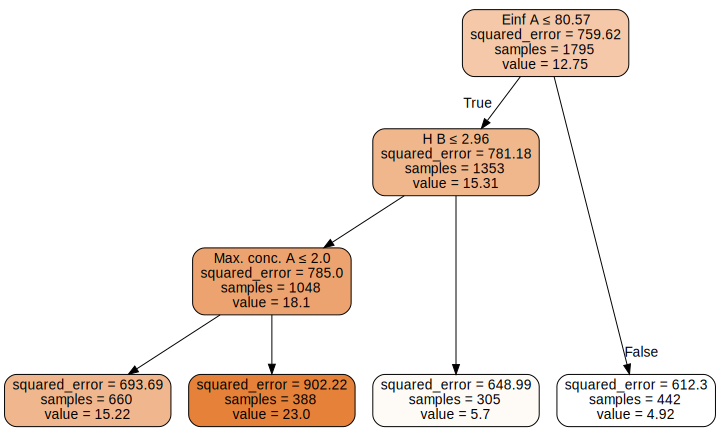

In [ ]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


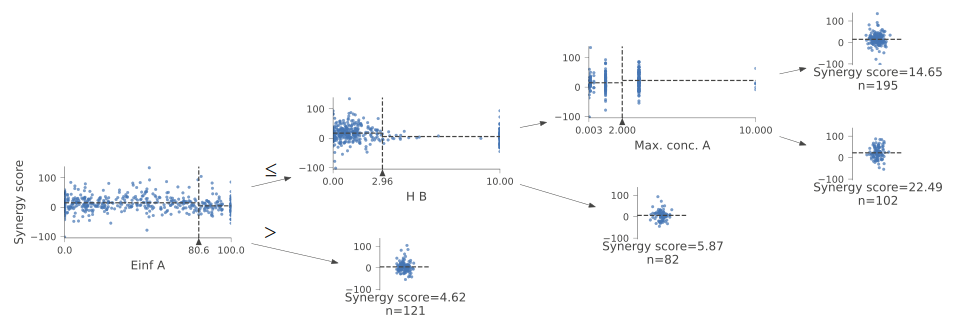

In [ ]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [ ]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [ ]:
m_rmse(m, valid_xs, valid_y)


36.81299

Now we will check for overfitting:

In [ ]:
m.get_n_leaves(), len(xs)

(1795, 1795)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.997595, 28.145969)

In [ ]:
m.get_n_leaves()


55

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [ ]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [ ]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 152 
 Error = 27.38495


Let's check our metric

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf = best_leaf)
m.fit(to.train.xs, to.train.y)
y_pred = m.predict(valid_xs)
print(test_df.shape)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)


(1089, 13)
Weighted Pearson:  nan
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


For some drug combination we obtain NaN's. My hypothesis is that for some drug pairs the predicted value is the same for all cell lines.

In [ ]:
check_nan = pear_weights_df["Pearson coefficient"].isnull()
combination_index = np.arange(pear_weights_df.shape[0], dtype = int)
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

,Combination ID,n_cl,Pearson coefficient
54,ALK.CSNK2A1_2,6,NaN
96,MTOR_1.TNKS_PARP6,7,NaN
133,Cisplatin.PIK3C,3,NaN
138,AKT.Cisplatin,3,NaN
148,AKT.Chloroquine,5,NaN
157,MTOR_1.SLC16A4,7,NaN


These are the drug combinations that have a NaN Pearson correlation. We pick the first one and check for the predicted values.

In [ ]:
nan_mask = test_df["Combination ID"] == "ALK.CSNK2A1_2"
ALK_CSNK2A1_2_df = test_df[nan_mask]
ALK_CSNK2A1_2_df

,Cell line name,Compound A,Compound B,Max. conc. A,...,H B,Einf B,Synergy score,Combination ID
217,NCI-H1563,CSNK2A1_2,ALK,0.03,...,1.831949,1.578234,5.147264,ALK.CSNK2A1_2
272,NCI-H522,CSNK2A1_2,ALK,0.03,...,1.652920,0.000000,-15.121200,ALK.CSNK2A1_2
1386,NCI-H2085,CSNK2A1_2,ALK,0.03,...,1.161107,0.000000,9.019851,ALK.CSNK2A1_2
1633,SW900,CSNK2A1_2,ALK,0.01,...,0.685584,0.000000,15.030920,ALK.CSNK2A1_2
3290,NCI-H2291,CSNK2A1_2,ALK,0.01,...,0.796128,0.000000,16.914830,ALK.CSNK2A1_2
3331,NCI-H838,CSNK2A1_2,ALK,0.10,...,1.619777,0.000000,16.545240,ALK.CSNK2A1_2


In [ ]:
y_pred_ALK_CSNK2A1_2 = y_pred[nan_mask]
y_pred_ALK_CSNK2A1_2

array([21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048])

Just as I imagined. We are predicting the same values over and over. That's why our metric fails.

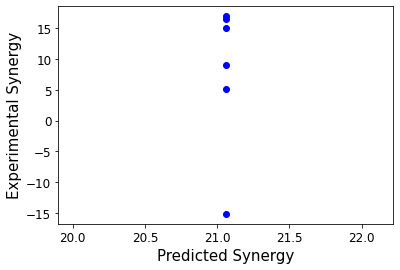

In [ ]:
plt.plot(y_pred_ALK_CSNK2A1_2 , ALK_CSNK2A1_2_df["Synergy score"] , "bo")
plt.ylabel("Experimental Synergy", fontsize = 15)
plt.xlabel("Predicted Synergy", fontsize = 15)
plt.savefig("predicted_experimental_synergy_decision_tree_nan.eps", format = 'eps', dpi=300)


Now with our metric function that takes nan's into account:


In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.11147801629765684
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Just to make sure we check for the previous rows of pear_weights_df where there were nan's.

In [ ]:
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

,Combination ID,n_cl,Pearson coefficient
54,ALK.CSNK2A1_2,6,0.0
96,MTOR_1.TNKS_PARP6,7,0.0
133,Cisplatin.PIK3C,3,0.0
138,AKT.Cisplatin,3,0.0
148,AKT.Chloroquine,5,0.0
157,MTOR_1.SLC16A4,7,0.0


The function works.

# Random Forest

In [ ]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(24.374761, 26.497797)

A little better than the Tree regressor, but not that great.

In [ ]:
y_pred = m.predict(valid_xs)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.16706360356491573
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.429530
1        FASN.MTOR_1     7            -0.013100
2         IAP.IGFR_3     3             0.884104
3        FGFR.MTOR_3     5             0.914940
4         IAP.PIK3CB    10             0.398945
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.755894
163      HSP90.PIK3C     3             0.304881
164  ATM.Gemcitabine     3            -0.278453
165     ATR_4.HDAC_4     3             0.999990
166   BCL2.CSNK2A1_2     6            -0.554555

[167 rows x 3 columns]


We see that Random Forest gives better prediction than Decision Trees. 

Let's try to obtain meaningful info. For example, let's order drug combinations from highest to lowest correlation

In [ ]:
ordered_df = pear_weights_df.sort_values(by = "Pearson coefficient",
                                         ascending = False)
print(ordered_df)

        Combination ID  n_cl  Pearson coefficient
165       ATR_4.HDAC_4     3             0.999990
31            FGFR.WNT     3             0.999920
8    Gemcitabine.PARP1     3             0.999857
156  EG5.PIK3CB_PIK3CD     3             0.998560
151        MAP2K_1.TKI     3             0.998325
..                 ...   ...                  ...
145  AKT_1.Chloroquine     5            -0.803913
148    AKT.Chloroquine     5            -0.807129
77            IAP.SN38     3            -0.971769
65      IGFR_4.MAP2K_1     3            -0.992857
85      IGFR_3.MAP2K_1     3            -0.996501

[167 rows x 3 columns]


Now the most uncorrelated:

In [ ]:
ordered_df["abs Pearson"] = np.abs(ordered_df["Pearson coefficient"])
ordered_df = ordered_df.sort_values(by ="abs Pearson",
                                         ascending = True)
ordered_df.head(10)

,Combination ID,n_cl,Pearson coefficient,abs Pearson
123,BCL2.MAP2K_1,3,0.005340,0.005340
122,FGFR.SLC16A4,6,-0.008699,0.008699
20,FGFR.TNKS_PARP6,7,-0.009324,0.009324
107,CarboTaxol.CSNK2A1_2,5,-0.009835,0.009835
1,FASN.MTOR_1,7,-0.013100,0.013100
137,AKT.HDAC_4,5,-0.015835,0.015835
117,ADAM17.BCL2_BCL2L1,7,0.022154,0.022154
13,ADAM17.PIK3CB_PIK3CD,8,-0.025216,0.025216
118,AKT.ATR_4,10,-0.027071,0.027071
149,Cisplatin.PARP1,3,0.028164,0.028164


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

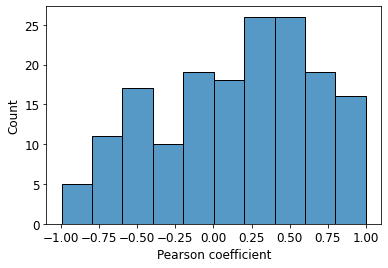

In [ ]:
sns.histplot(data = ordered_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_random_forest.eps", format = 'eps', dpi=300)


Let's try to do a bit of hyperparameter tuning to check for the best hyperparameters for random forest. 

In [ ]:
def rf_training(xs, y, test_df, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, random_state = 42, **kwargs):
   m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf,random_state = random_state , 
        oob_score=True)
   m.fit(xs, y)      
   y_pred = m.predict(valid_xs)
   weighted_pear = wpc_score(test_df, y_pred)
   return weighted_pear

Let's try our function and see if it reproduces previous results.

In [ ]:
rf_training(xs, y, test_df)

0.186327856782357

Close enough, the small difference can be explained by the fact that we didn't fix the random seed. Let's try some hyperparameter tuning.

# Tabular learner fastai
As next model we will try a Tabular Learner from FastAI. 
First thing we have to do is normalize the data. We create another TabularPandas object:


In [31]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits)

Now we create our dataloader and check for the maximum and minimum of our data. This is useful as we will limit the output interval of our model

In [ ]:
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()

(-178.6540985107422, 237.37640380859375)

We create our learner and look for an optimal learning rate with lr_find.

SuggestedLRs(valley=0.0010000000474974513)

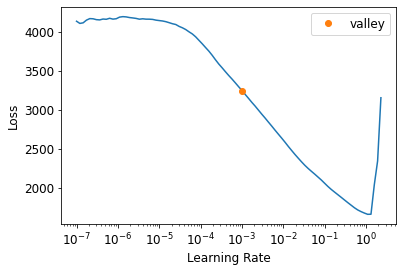

In [ ]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[200,50, 20],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()


Now we finetune our learner by a few epochs.



In [ ]:
learn.fit_one_cycle(50, 1e-3)


epoch,train_loss,valid_loss,time
0,4117.541504,1458.527344,00:00
1,4028.859131,1391.474365,00:00
2,3947.213135,1327.601074,00:00
3,3866.347656,1264.543091,00:00
4,3689.180908,1205.392090,00:00
5,3536.247314,1150.564453,00:00
6,3368.241211,1101.905273,00:00
7,3209.256348,1057.416626,00:00
8,3061.905518,1017.447632,00:00
9,2943.799072,981.191895,00:00


Lastly, we obtain our predictions and compute the WPC metric. Since the FastAI learner outputs a tensor, we have to Flatten it.


In [ ]:
y_pred, targs = learn.get_preds()
y_pred = np.asarray(y_pred[:,0])
wpc_score(test_df, y_pred)


0.10968063703535985

In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.10968063703535985
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.727809
1        FASN.MTOR_1     7             0.467770
2         IAP.IGFR_3     3            -0.944783
3        FGFR.MTOR_3     5             0.505273
4         IAP.PIK3CB    10             0.643841
..               ...   ...                  ...
162   Cisplatin.FGFR     3             0.678983
163      HSP90.PIK3C     3            -0.456856
164  ATM.Gemcitabine     3             0.647182
165     ATR_4.HDAC_4     3             0.328268
166   BCL2.CSNK2A1_2     6             0.292057

[167 rows x 3 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

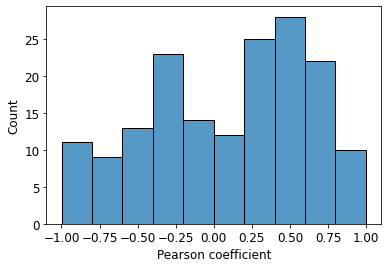

In [ ]:
sns.histplot(data = pear_weights_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_tabular_learner.eps", format = 'eps', dpi=300)

# Ensemble: Tabular Learner + Random Forest.

We will average predictions between Tabular Learner and Random Forest to create a superior model.

In [ ]:
"Random Forest"
m_rf = rf(xs, y);
"We take the two permutations and average"
y_pred_rf_1 = m_rf.predict(valid_xs)
y_pred_rf_2 = m_rf.predict(valid_xs_perm)
y_pred_rf = (y_pred_rf_1 + y_pred_rf_2)/2
wpc_score(test_df, y_pred_rf)


0.18972436901425996

Let's see if performance increases when we use pearson correlation coefficient as metric and EarlyStopping and SaveModelCallback callbacks

In [33]:
"Tabular learner"
procs_nn = [Categorify, FillMissing, Normalize]
"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"
to_nn = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits)
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()

callbacks = [EarlyStoppingCallback(
    monitor='pearsonr',
    min_delta=0.01, patience=20), SaveModelCallback(monitor='pearsonr')]


learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[30,20, 10],
                        n_out=1, loss_func=F.mse_loss, 
                        metrics = PearsonCorrCoef(), cbs = callbacks)
#learn.lr_find()


epoch,train_loss,valid_loss,pearsonr,time
0,2439.272461,789.957275,0.066300,00:00
1,1959.203003,778.613953,0.088198,00:00
2,1676.245605,776.956726,0.104125,00:00
3,1511.138916,786.300476,0.116763,00:00
4,1379.007812,812.854065,0.125743,00:00
5,1284.009644,846.582764,0.133607,00:00
6,1205.768433,879.488464,0.141254,00:00
7,1144.984009,893.779541,0.152445,00:00
8,1090.873291,884.451416,0.167735,00:00
9,1045.474976,853.820068,0.190987,00:00


Better model found at epoch 0 with pearsonr value: 0.0662998365347577.
Better model found at epoch 1 with pearsonr value: 0.08819803788881193.
Better model found at epoch 2 with pearsonr value: 0.10412519576408763.
Better model found at epoch 3 with pearsonr value: 0.11676289292316545.
Better model found at epoch 4 with pearsonr value: 0.1257426500354565.
Better model found at epoch 5 with pearsonr value: 0.13360743228384897.
Better model found at epoch 6 with pearsonr value: 0.14125400765387935.
Better model found at epoch 7 with pearsonr value: 0.15244548741405486.
Better model found at epoch 8 with pearsonr value: 0.16773460609793533.
Better model found at epoch 9 with pearsonr value: 0.19098659248511946.
Better model found at epoch 10 with pearsonr value: 0.22738080417293932.
Better model found at epoch 11 with pearsonr value: 0.2709957459663443.
Better model found at epoch 12 with pearsonr value: 0.30788745693680614.
Better model found at epoch 13 with pearsonr value: 0.3358159692

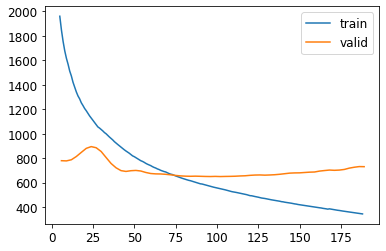

In [ ]:
learn.fit(n_epoch = 300, lr = 0.001)
learn.recorder.plot_loss()

In [ ]:
y_pred_nn_1, targs = learn.get_preds()
y_pred_nn_1 = np.asarray(y_pred_nn_1[:,0])


wpc_score(test_df, y_pred_nn_1)

0.22842532778420135

let's save this learner and try to optimise it more.

In [ ]:
learn.save("/content/drive/MyDrive/archivos_tfm/tabular_model_commutative.pth")

Path('/content/drive/MyDrive/archivos_tfm/tabular_model_commutative.pth.pth')

In [44]:
"And load it"
learn.load("/content/drive/MyDrive/archivos_tfm/tabular_model_commutative.pth")
y_pred_nn_1, targs = learn.get_preds()
y_pred_nn_1 = np.asarray(y_pred_nn_1[:,0])


wpc_score(test_df, y_pred_nn_1)

0.22842532778420135

In [ ]:
valid_xs_perm_nn = to_nn.valid.xs.copy()

valid_xs_perm_nn[[ 'Compound A', 'Compound B', 
                         'Max. conc. A',
                         'Max. conc. B', 
                         'IC50 A', 'H A', 
                         'Einf A', 'IC50 B', 
                         'H B', 'Einf B']] = to_nn.valid.xs[[ 'Compound B', 'Compound A', 
                         'Max. conc. B',
                         'Max. conc. A', 
                         'IC50 B', 'H B', 
                         'Einf B', 'IC50 A', 
                         'H A', 'Einf A']]
valid_xs_perm_nn

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf A,IC50 B,H B,Einf B
5,32,2,32,1.0,...,58.538452,1.000008,10.000000,78.399574
11,7,2,49,1.0,...,34.658417,1.000000,0.556940,54.700432
19,51,27,40,1.0,...,100.000000,1.000000,10.000000,93.800095
33,35,1,2,75.0,...,73.495689,1.000000,0.258988,17.701706
40,28,11,36,3.0,...,0.764862,0.006467,0.244922,0.000000
...,...,...,...,...,...,...,...,...,...
5256,51,1,2,75.0,...,100.000000,0.226297,1.952148,17.477798
5260,26,31,43,1.0,...,75.080116,0.068121,2.789950,27.901039
5261,71,40,61,3.0,...,0.000000,1.000000,0.000000,100.000000
5262,9,51,64,1.0,...,70.299622,0.009716,0.380575,38.365410


In [ ]:
y_pred_nn_2, targs = learn.predict(valid_xs_perm_nn)
y_pred_nn_2 = np.asarray(y_pred_nn_2[:,0])


wpc_score(test_df, y_pred_nn_2)

AttributeError: ignored

I have not been able to use valid_xs_perm_nn to predict something in the tabular learner.

All together:

In [ ]:
y_pred_avg = (y_pred_rf + y_pred_nn_1 )/ 2
wpc_score(test_df, y_pred_avg)

0.2558716549520519

# XGBOOST

Out of curiosity, let's try XGBoost and ensemble it.

In [ ]:
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs, y)
y_pred_xgb_1 = m_xgb.predict(valid_xs)
y_pred_xgb_2 = m_xgb.predict(valid_xs_perm)
y_pred_xgb = (y_pred_xgb_1 + y_pred_xgb_2)
wpc_score(test_df, y_pred_xgb)


[12:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.26399471855306117

Now we ensemble RF, XGBoost and Tabular Learner.

In [ ]:
y_pred_avg = (y_pred_rf + y_pred_nn_1 + y_pred_xgb)/ 3
wpc_score(test_df, y_pred_avg)

0.2891897769098425

And only Random Forest and XGBoost

In [ ]:
y_pred_avg = (y_pred_rf +  y_pred_xgb)/ 2
wpc_score(test_df, y_pred_avg)

0.27029440238974517

# Support Vector Regressor

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb, procs_nn, cat, cont, y_names=dep_var, 
                      splits=splits)


In [ ]:
m_SVR = SVR(kernel="linear")
m_SVR.fit(to_nn.train.xs, to_nn.train.y)
y_pred_SVR = m_SVR.predict(to_nn.valid.xs)

wpc_score(test_df, y_pred_SVR)

0.14470302399770377

With both permutations

In [ ]:
m_SVR = SVR(kernel="linear")
m_SVR.fit(xs, y)
y_pred_SVR_1 = m_SVR.predict(valid_xs)
y_pred_SVR_2 = m_SVR.predict(valid_xs_perm)
y_pred_SVR = (y_pred_SVR_1 + y_pred_SVR_2)/2

wpc_score(test_df, y_pred_SVR)

0.14511698665160222

Now we ensemble the 4 of them:
Random Forest + XGBoost + Neural Networks + SVM

In [ ]:
y_pred_avg = (y_pred_rf + y_pred_nn_1 + y_pred_xgb + y_pred_SVR)/ 4
wpc_score(test_df, y_pred_avg)

0.2941978824723345

## Feature importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m_rf, xs)
fi[:10]

,cols,imp
0,Cell line name,0.122700
7,Einf A,0.119059
9,H B,0.117066
10,Einf B,0.109905
6,H A,0.107753
8,IC50 B,0.097234
5,IC50 A,0.094072
1,Compound A,0.081534
2,Compound B,0.081325
3,Max. conc. A,0.038421


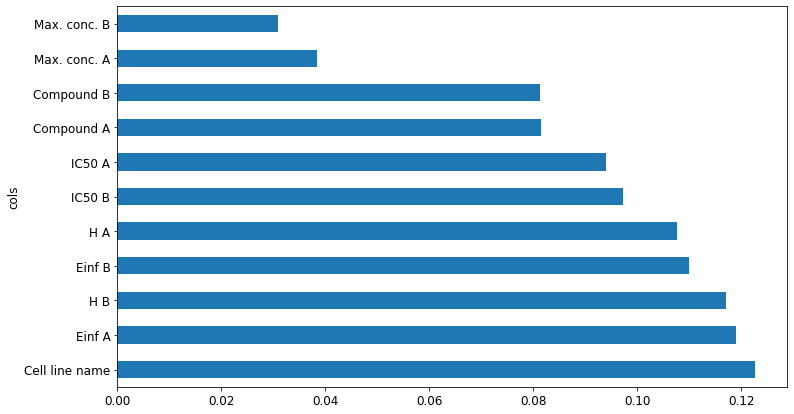

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Here we don't have a lot of columns, so we don't have
to erase any of them.

# Creating new features:

We will try to do some feature engineering.

First we are going to create features independent of the order of the drugs, since we would want our input to be commutative with respect to the drug.

In [ ]:
df_nocomb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score'],
      dtype='object')

In [ ]:
df_new_f = pd.DataFrame()
df_new_f[['Cell line name', 
          'Compound A', 'Compound B', 
          'Synergy score']] = df_nocomb[['Cell line name', 'Compound A', 
                     'Compound B', 'Synergy score']]
df_new_f["Av_max_conc"] =  (df_nocomb['Max. conc. A'] + df_nocomb['Max. conc. B']) / 2

df_new_f["abs_dif_max_conc"] =  np.abs(df_nocomb['Max. conc. A'] - df_nocomb['Max. conc. B'])

df_new_f["Av_IC50"] =  (df_nocomb['IC50 A'] + df_nocomb['IC50 B']) / 2

df_new_f["abs_dif_IC50"] =  np.abs(df_nocomb['IC50 A'] - df_nocomb['IC50 B'])

df_new_f["Av_H"] =  (df_nocomb['H A'] + df_nocomb['H B']) / 2

df_new_f["abs_dif_IC50"] =  np.abs(df_nocomb['H A'] + df_nocomb['H B'])

df_new_f["Av_Einf"] =  (df_nocomb['Einf A'] + df_nocomb['Einf B']) / 2

df_new_f["abs_dif_Einf"] =  np.abs(df_nocomb['Einf A'] + df_nocomb['Einf B'])

df_new_f


,Cell line name,Compound A,Compound B,Synergy score,...,abs_dif_IC50,Av_H,Av_Einf,abs_dif_Einf
0,HCC1143,FGFR,EGFR,25.848650,...,1.106136,0.553068,82.493124,164.986248
1,MDA-MB-468,PIK3C,AKT_1,24.378630,...,11.502789,5.751395,34.949883,69.899766
2,MFM-223,MAP2K_1,ATR_4,-19.085140,...,10.000000,5.000000,87.549419,175.098838
3,BT-20,MTOR_1,FASN,20.951370,...,1.660213,0.830107,7.193071,14.386142
4,SW948,IGFR_3,IAP,40.200730,...,1.233020,0.616510,49.210384,98.420767
...,...,...,...,...,...,...,...,...,...
3470,RKO,JAK,IAP,-1.023761,...,11.452473,5.726236,41.609320,83.218641
3471,NCI-H1703,PIK3CA_3,IAP,12.894160,...,2.845207,1.422604,9.990222,19.980445
3472,SW948,PTK2,MAP2K_1,19.809670,...,2.290002,1.145001,4.404042,8.808083
3473,MDA-MB-453,PIK3C,ESR1_1,47.096230,...,2.648087,1.324043,24.829379,49.658758


In [ ]:
cont,cat = cont_cat_split(df_new_f, 1, dep_var=dep_var)
to_new_f = TabularPandas(df_new_f, procs, cat, cont, y_names=dep_var, 
                         splits=splits)
xs_new_f, y_new_f = to_new_f.train.xs, to_new_f.train.y
valid_xs_new_f, valid_y_new_f = to_new_f.valid.xs, to_new_f.valid.y

In [ ]:
"Random Forest"
m_rf = rf(xs_new_f, y_new_f, n_estimators=100, max_samples=500,
       max_features=0.7, min_samples_leaf=1 , random_state = 42);
y_pred_rf_new_f = m_rf.predict(valid_xs_new_f)
wpc_score(test_df, y_pred_rf_new_f)


KeyboardInterrupt: ignored

In [ ]:
"XGBoost"
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs_new_f, y_new_f)
y_pred_xgb_new_f = m_xgb.predict(valid_xs_new_f)
wpc_score(test_df, y_pred_xgb_new_f)

It's doesn't improve predictions. We have to look in other direction. 

# Visualizing Tabular Learner Model and extracting embedding dictionaries for Cell line, Compound A and Compound B.

First we try to see the model architecture

In [73]:
print(learn)

In [49]:
def nested_children(m: torch.nn.Module):
    children = dict(m.named_children())
    output = {}
    if children == {}:
        # if module has no children; m is last child! :O
        return m
    else:
        # look for children from children... to the last child!
        for name, child in children.items():
            try:
                output[name] = nested_children(child)
            except TypeError:
                output[name] = nested_children(child)
    return output

model_layers = nested_children(learn)


In [50]:
model_layers

{'bn_cont': BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 'emb_drop': Dropout(p=0.0, inplace=False),
 'embeds': {'0': Embedding(86, 19),
  '1': Embedding(70, 17),
  '2': Embedding(70, 17)},
 'layers': {'0': {'0': Linear(in_features=61, out_features=30, bias=False),
   '1': ReLU(inplace=True),
   '2': BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)},
  '1': {'0': Linear(in_features=30, out_features=20, bias=False),
   '1': ReLU(inplace=True),
   '2': BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)},
  '2': {'0': Linear(in_features=20, out_features=10, bias=False),
   '1': ReLU(inplace=True),
   '2': BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)},
  '3': {'0': Linear(in_features=10, out_features=1, bias=True)},
  '4': SigmoidRange(low=-178.6540985107422, high=237.37640380859375)}}

In [52]:
named_layers = dict(learn.named_modules())
print(named_layers)

{'': TabularModel(
  (embeds): ModuleList(
    (0): Embedding(86, 19)
    (1): Embedding(70, 17)
    (2): Embedding(70, 17)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=61, out_features=30, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=30, out_features=20, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=20, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=10, out_features=1, bias=True)
 

In [57]:
valid_xs.shape

(1089, 11)

Now we extract the embedding dictionary

In [70]:
embedding = learn.embeds
print(embedding.named_modules)

<bound method Module.named_modules of ModuleList(
  (0): Embedding(86, 19)
  (1): Embedding(70, 17)
  (2): Embedding(70, 17)
)>


In [74]:
print("Number of cell lines: " , len(xs["Cell line name"].unique()))
print("Number of Drugs A: " , len(xs["Compound A"].unique()))
print("Number of Drugs B: " , len(xs["Compound B"].unique()))

Number of cell lines:  84
Number of Drugs A:  69
Number of Drugs B:  69


In [75]:
print(learn.model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(86, 19)
    (1): Embedding(70, 17)
    (2): Embedding(70, 17)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=61, out_features=30, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=30, out_features=20, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=20, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )


In [95]:
summary(learn.model, 11)

TypeError: ignored

In [87]:
embedding_0 = embedding[0]


In [98]:
input = torch.LongTensor([0])
embedding_0(input)

tensor([[-0.0076,  0.0123, -0.0196,  0.0108,  0.0075, -0.0086,  0.0070, -0.0084, -0.0026,  0.0053,  0.0023,  0.0088,  0.0039, -0.0115, -0.0034,  0.0109,  0.0091,  0.0008, -0.0063]],
       grad_fn=<EmbeddingBackward0>)

In [99]:
valid_xs

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf A,IC50 B,H B,Einf B
5,32,32,2,3.0,...,78.399574,0.099498,2.531000,58.538452
11,7,49,2,1.0,...,54.700432,0.235409,1.182479,34.658417
19,51,40,27,1.0,...,93.800095,1.000000,0.000000,100.000000
33,35,2,1,1.0,...,17.701706,0.540880,4.851464,73.495689
40,28,36,11,3.0,...,0.000000,3.000000,0.103996,0.764862
...,...,...,...,...,...,...,...,...,...
5256,51,2,1,1.0,...,17.477798,1.000000,0.000000,100.000000
5260,26,43,31,1.0,...,27.901039,0.051205,10.000000,75.080116
5261,71,61,40,3.0,...,100.000000,3.000000,0.969392,0.000000
5262,9,64,51,1.0,...,38.365410,0.249083,10.000000,70.299622


Vamos a obtener los diccionarios de las cell lines,  compound A y compound B 

In [135]:
cl_cat_to_int = dict(zip(test_df["Cell line name"], valid_xs["Cell line name"]))
cl_embedding_dict = dict()
for i, cat in enumerate(cl_cat_to_int):
  cl_embedding_dict[(cat)] = embedding_0(torch.LongTensor([i])).detach().numpy()

In [136]:
cl_embedding_dict

{'22RV1': array([[-0.00897543,  0.02598321,  0.02002143, -0.00573113,  0.00226387,  0.02977065, -0.01245474,  0.00524208,  0.05333259, -0.01239858,  0.01318895,  0.0021014 ,  0.02188591,  0.01021426,
          0.02383813,  0.00319444, -0.00712638,  0.04447477,  0.02945668]], dtype=float32),
 '647-V': array([[-0.00447433,  0.01506898,  0.00816659, -0.03942322, -0.00502857, -0.01771179,  0.04537631, -0.02959894,  0.03722197, -0.03224654,  0.03485535,  0.01575203, -0.00748616,  0.03041947,
         -0.00337443, -0.0128513 ,  0.04984659,  0.02184376, -0.00169032]], dtype=float32),
 'A549': array([[-0.03759567, -0.00413775, -0.02164523, -0.00979365,  0.03212807,  0.05098707,  0.01294662,  0.00377404,  0.05147869, -0.03898619,  0.0135082 ,  0.00107821, -0.02103001,  0.00875649,
          0.01674271, -0.00714688,  0.01094464,  0.02514663, -0.05880581]], dtype=float32),
 'BFTC-905': array([[ 0.05227358,  0.0273341 , -0.02440725, -0.0625549 ,  0.01455268,  0.02714257,  0.06207589,  0.04360477, 

In [137]:
embedding_1 = embedding[1]
Compound_A_cat_to_int = dict(zip(test_df["Compound A"], valid_xs["Compound A"]))
Compound_A_embedding_dict = dict()
for i, cat in enumerate(Compound_A_cat_to_int):
  Compound_A_embedding_dict[(cat)] = embedding_1(torch.LongTensor([i])).detach().numpy()

In [138]:
Compound_A_embedding_dict

{'AKT': array([[-0.02647507,  0.0174162 , -0.03829989,  0.01048459,  0.00944627,  0.04841933, -0.01175978, -0.01094781, -0.00642714, -0.01783823, -0.02410454, -0.01503472,  0.01422337,  0.00787178,
         -0.00838627,  0.02497517, -0.02419231]], dtype=float32),
 'AKT_1': array([[ 0.0443061 ,  0.06800702, -0.01930578, -0.01044444,  0.02041329,  0.02715674, -0.01326696,  0.01072615,  0.00728724,  0.01418323, -0.02420046, -0.02371309,  0.02380822,  0.02331861,
         -0.01922753, -0.02500356, -0.03179255]], dtype=float32),
 'ALK_IGFR': array([[-0.03588109,  0.01404548, -0.00811012, -0.01418318, -0.01446435,  0.01049848, -0.01424283,  0.01092361,  0.00841047,  0.03578247,  0.01335141, -0.02546551, -0.01852539, -0.00143259,
          0.03609972, -0.02396003, -0.02036897]], dtype=float32),
 'ATR_4': array([[ 0.00737876, -0.06606667,  0.04147857, -0.01603118,  0.02519993,  0.01219589,  0.05071529, -0.01577407,  0.03170373, -0.03933052, -0.02720767,  0.03173883,  0.03025031, -0.05205555,
 

In [139]:
embedding_2 = embedding[2]
Compound_B_cat_to_int = dict(zip(test_df["Compound B"], valid_xs["Compound B"]))
Compound_B_embedding_dict = dict()
for i, cat in enumerate(Compound_B_cat_to_int):
  Compound_B_embedding_dict[(cat)] = embedding_2(torch.LongTensor([i])).detach().numpy()
Compound_B_embedding_dict

{'ADAM17': array([[ 3.8339975e-05, -1.5452372e-02,  1.1323296e-02,  2.8272854e-02, -2.1546476e-03,  1.8089056e-02, -2.0200517e-02,  2.2246605e-02, -3.2967947e-02,  2.9574785e-02, -1.9102411e-02,
         -1.4448717e-02,  2.8151255e-03, -2.9226093e-02, -4.9022166e-03,  3.3816640e-04,  2.0470250e-02]], dtype=float32),
 'AKT': array([[-0.00553862, -0.00201186,  0.00043135,  0.00256823,  0.00166286, -0.01160177,  0.00896006,  0.00945446,  0.00409647,  0.00210936,  0.01505675, -0.00124546, -0.00962757,  0.01465866,
          0.00081092,  0.00119134, -0.00242015]], dtype=float32),
 'AKT_1': array([[ 0.0352821 , -0.01259737,  0.03217355, -0.00444659,  0.01195889,  0.03102946, -0.04952654, -0.02742838,  0.0140539 , -0.00977929,  0.03246417,  0.00274946,  0.00753881, -0.00052312,
         -0.01298804, -0.03982118,  0.023619  ]], dtype=float32),
 'AKT_SGK': array([[ 0.01518066, -0.04462318, -0.0070426 ,  0.04669243, -0.03644916,  0.01789666,  0.01712859, -0.00196855, -0.04805664,  0.05580732,  0

We are going to save those dictionaries for latter. We will use pickle

In [141]:
with open('/content/drive/MyDrive/archivos_tfm/cl_embedding_dict.pkl', 'wb') as f:
    pickle.dump(cl_embedding_dict, f)

with open('/content/drive/MyDrive/archivos_tfm/Compound_A_embedding_dict.pkl', 'wb') as f:
    pickle.dump(Compound_A_embedding_dict, f)

with open('/content/drive/MyDrive/archivos_tfm/Compound_B_embedding_dict.pkl', 'wb') as f:
    pickle.dump(Compound_B_embedding_dict, f) 



Let's see if it works

In [142]:
with open('/content/drive/MyDrive/archivos_tfm/Compound_B_embedding_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

loaded_dict

{'ADAM17': array([[ 3.8339975e-05, -1.5452372e-02,  1.1323296e-02,  2.8272854e-02, -2.1546476e-03,  1.8089056e-02, -2.0200517e-02,  2.2246605e-02, -3.2967947e-02,  2.9574785e-02, -1.9102411e-02,
         -1.4448717e-02,  2.8151255e-03, -2.9226093e-02, -4.9022166e-03,  3.3816640e-04,  2.0470250e-02]], dtype=float32),
 'AKT': array([[-0.00553862, -0.00201186,  0.00043135,  0.00256823,  0.00166286, -0.01160177,  0.00896006,  0.00945446,  0.00409647,  0.00210936,  0.01505675, -0.00124546, -0.00962757,  0.01465866,
          0.00081092,  0.00119134, -0.00242015]], dtype=float32),
 'AKT_1': array([[ 0.0352821 , -0.01259737,  0.03217355, -0.00444659,  0.01195889,  0.03102946, -0.04952654, -0.02742838,  0.0140539 , -0.00977929,  0.03246417,  0.00274946,  0.00753881, -0.00052312,
         -0.01298804, -0.03982118,  0.023619  ]], dtype=float32),
 'AKT_SGK': array([[ 0.01518066, -0.04462318, -0.0070426 ,  0.04669243, -0.03644916,  0.01789666,  0.01712859, -0.00196855, -0.04805664,  0.05580732,  0

It is correct